In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
land_mask = xr.open_dataset("../data/Land_mask.nc")
land_mask

<xarray.Dataset> Size: 1MB
Dimensions:    (lat: 720, lon: 1440)
Coordinates:
  * lat        (lat) float64 6kB 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * lon        (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
    time       datetime64[ns] 8B ...
Data variables:
    land_mask  (lat, lon) bool 1MB ...

## Extend GLEAM

In [3]:
gleam_folder = "../data/GLEAMv4a_SMrz"
gleams = xr.open_mfdataset(f"{gleam_folder}/*.nc", combine="by_coords", parallel=True)
gleams

<xarray.Dataset> Size: 14GB
Dimensions:  (time: 540, lat: 1800, lon: 3600)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1980-01-31 1980-02-29 ... 2024-12-31
  * lat      (lat) float64 14kB 89.95 89.85 89.75 89.65 ... -89.75 -89.85 -89.95
  * lon      (lon) float64 29kB -179.9 -179.8 -179.8 ... 179.7 179.8 179.9
Data variables:
    SMrz     (time, lat, lon) float32 14GB dask.array<chunksize=(4, 600, 1200), meta=np.ndarray>
Attributes:
    Dataset:      Global Land Evaporation Amsterdam Model
    Version:      4.2a
    Authors:      Hydro-Climate Extremes Lab (H-CEL)
    Institution:  Ghent University
    Contact:      info@gleam.eu
    Reference1:   Miralles, D.G. et al. 2011: Global land-surface evaporation...
    Reference2:   Miralles, D. G., Bonte, O., Koppa, A., Villanueva, O. B., T...

In [5]:
gleams_resampled = gleams.interp(lat=land_mask.lat, lon=land_mask.lon, time=gleams.time)
gleams_resampled

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 540, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1980-01-31 1980-02-29 ... 2024-12-31
  * lat      (lat) float64 6kB 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    SMrz     (time, lat, lon) float32 2GB dask.array<chunksize=(540, 10, 60), meta=np.ndarray>
Attributes:
    Dataset:      Global Land Evaporation Amsterdam Model
    Version:      4.2a
    Authors:      Hydro-Climate Extremes Lab (H-CEL)
    Institution:  Ghent University
    Contact:      info@gleam.eu
    Reference1:   Miralles, D.G. et al. 2011: Global land-surface evaporation...
    Reference2:   Miralles, D. G., Bonte, O., Koppa, A., Villanueva, O. B., T...

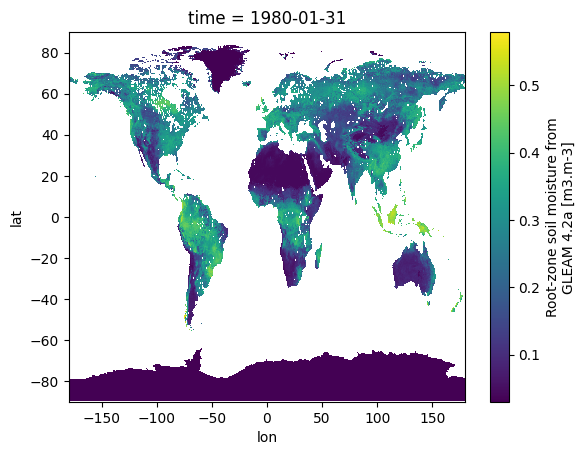

In [6]:
gleams_resampled.isel(time=0).SMrz.plot()

In [8]:
gleams_resampled = gleams_resampled.assign_coords(
    time=pd.date_range("1980-01-01", "2024-12-01", freq="MS")
)

In [9]:
gleams_resampled.to_netcdf("../data/clean/GLEAM4a_sm.nc")

## Extend MSWEP

In [3]:
msweps = xr.open_mfdataset(
    "../data/MSWEP_2024/*.nc", combine="by_coords", parallel=True
)
msweps

<xarray.Dataset> Size: 311MB
Dimensions:        (time: 12, lat: 1800, lon: 3600)
Coordinates:
  * time           (time) datetime64[ns] 96B 2024-01-01 ... 2024-12-01T06:28:...
  * lat            (lat) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon            (lon) float32 14kB -179.9 -179.8 -179.8 ... 179.8 179.9 179.9
Data variables:
    precipitation  (time, lat, lon) float32 311MB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
Attributes:
    history:          Created on 2025-08-20 16:22
    input_data_hash:  0b9dd0509f437488bd804a878646f2489b55a89bf2e67d05626f925...

In [4]:
old_msweps = xr.open_dataset("../data/clean/MSWEP_pre.nc")
old_msweps

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 528, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1980-01-01 1980-02-01 ... 2023-12-01
  * lat      (lat) float64 6kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    pre      (time, lat, lon) float32 2GB ...
Attributes:
    source:   Generated by BogangDong

In [5]:
msweps = msweps.assign_coords(time=pd.date_range("2024-01-01", "2024-12-01", freq="MS"))
msweps

<xarray.Dataset> Size: 311MB
Dimensions:        (time: 12, lat: 1800, lon: 3600)
Coordinates:
  * time           (time) datetime64[ns] 96B 2024-01-01 ... 2024-12-01
  * lat            (lat) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon            (lon) float32 14kB -179.9 -179.8 -179.8 ... 179.8 179.9 179.9
Data variables:
    precipitation  (time, lat, lon) float32 311MB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
Attributes:
    history:          Created on 2025-08-20 16:22
    input_data_hash:  0b9dd0509f437488bd804a878646f2489b55a89bf2e67d05626f925...

In [6]:
# flip the latitudes
msweps = msweps.reindex(lat=msweps.lat[::-1])
msweps

<xarray.Dataset> Size: 311MB
Dimensions:        (lon: 3600, lat: 1800, time: 12)
Coordinates:
  * lon            (lon) float32 14kB -179.9 -179.8 -179.8 ... 179.8 179.9 179.9
  * lat            (lat) float32 7kB -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
  * time           (time) datetime64[ns] 96B 2024-01-01 ... 2024-12-01
Data variables:
    precipitation  (time, lat, lon) float32 311MB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
Attributes:
    history:          Created on 2025-08-20 16:22
    input_data_hash:  0b9dd0509f437488bd804a878646f2489b55a89bf2e67d05626f925...

In [7]:
msweps_resampled = msweps.interp(
    lat=old_msweps.lat, lon=old_msweps.lon, time=msweps.time
)
msweps_resampled

<xarray.Dataset> Size: 50MB
Dimensions:        (time: 12, lat: 720, lon: 1440)
Coordinates:
  * time           (time) datetime64[ns] 96B 2024-01-01 ... 2024-12-01
  * lat            (lat) float64 6kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon            (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    precipitation  (time, lat, lon) float32 50MB dask.array<chunksize=(12, 2, 288), meta=np.ndarray>
Attributes:
    history:          Created on 2025-08-20 16:22
    input_data_hash:  0b9dd0509f437488bd804a878646f2489b55a89bf2e67d05626f925...

In [11]:
msweps_resampled.to_netcdf("../data/MSWEP_2024_resampled.nc")

In [12]:
msweps_resampled = xr.open_dataset("../data/MSWEP_2024_resampled.nc")
msweps_resampled

<xarray.Dataset> Size: 50MB
Dimensions:        (time: 12, lat: 720, lon: 1440)
Coordinates:
  * time           (time) datetime64[ns] 96B 2024-01-01 ... 2024-12-01
  * lat            (lat) float64 6kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon            (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    precipitation  (time, lat, lon) float32 50MB ...
Attributes:
    history:          Created on 2025-08-20 16:22
    input_data_hash:  0b9dd0509f437488bd804a878646f2489b55a89bf2e67d05626f925...

In [13]:
msweps_extended = xr.concat(
    [old_msweps["pre"], msweps_resampled["precipitation"]], dim="time"
)
msweps_extended = msweps_extended.assign_coords(
    time=pd.date_range("1980-01-01", "2024-12-01", freq="MS")
)
msweps_extended

<xarray.DataArray 'pre' (time: 540, lat: 720, lon: 1440)> Size: 2GB
array([[[ 0.725    ,  0.725    ,  0.725    , ...,  0.725    ,
          0.725    ,  0.725    ],
        [ 0.825    ,  0.825    ,  0.825    , ...,  0.825    ,
          0.825    ,  0.825    ],
        [ 0.6375   ,  0.6375   ,  0.6375   , ...,  0.6375   ,
          0.6375   ,  0.6375   ],
        ...,
        [10.3625   , 10.3175   , 10.2875   , ..., 10.4075   ,
         10.4      , 10.4      ],
        [10.7425   , 10.7175   , 10.6675   , ..., 10.735    ,
         10.75     , 10.765    ],
        [11.0775   , 11.1025   , 11.0925   , ..., 11.04     ,
         11.04     , 11.065    ]],

       [[ 2.625    ,  2.625    ,  2.625    , ...,  2.65     ,
          2.635    ,  2.625    ],
        [ 2.975    ,  2.975    ,  2.975    , ...,  2.975    ,
          2.975    ,  2.975    ],
        [ 3.575    ,  3.575    ,  3.575    , ...,  3.5375   ,
          3.545    ,  3.55     ],
...
        [ 0.2734375,  0.2734375,  0.1796875, ...,  2.0859375,
          2.125    ,  3.109375 ],
        [ 0.53125  ,  0.53125  ,  0.53125  , ...,  2.6796875,
          2.7109375,  3.75     ],
        [ 1.1015625,  1.1015625,  1.1015625, ...,  2.8125   ,
          2.8125   ,  3.609375 ]],

       [[ 3.4882467,  3.4862943,  3.4862943, ..., 25.24034  ,
         25.24034  , 27.484367 ],
        [ 6.7825985,  6.8729963,  6.853466 , ..., 25.971197 ,
         25.971197 , 30.219019 ],
        [12.075121 , 11.965741 , 11.80557  , ..., 40.700603 ,
         40.722088 , 45.285828 ],
        ...,
        [ 1.0625   ,  1.0625   ,  1.03125  , ...,  5.6796875,
          5.6875   ,  8.3671875],
        [ 0.890625 ,  0.890625 ,  0.8203125, ...,  5.71875  ,
          5.71875  ,  7.96875  ],
        [ 0.6171875,  0.6171875,  0.6171875, ...,  4.84375  ,
          4.84375  ,  6.8203125]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1980-01-01 1980-02-01 ... 2024-12-01
  * lat      (lat) float64 6kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Attributes:
    long_name:  total precipitation
    units:      mm/month mean

In [16]:
msweps_extended.to_netcdf("../data/clean/MSWEP_pre2.nc")

## Extend ERA5

In [3]:
era5_new = xr.open_dataset("../data/era5_tmp_2024.nc")
era5_new

<xarray.Dataset> Size: 50MB
Dimensions:     (valid_time: 12, latitude: 721, longitude: 1440)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 96B 2024-01-01 ... 2024-12-01
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    number      int64 8B ...
    expver      (valid_time) <U4 192B ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 50MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-28T07:39 GRIB to CDM+CF via cfgrib-0.9.1...

In [4]:
era5_old = xr.open_dataset("../data/clean/ERA5_tmp.nc")
era5_old

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 528, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1980-01-01 1980-02-01 ... 2023-12-01
  * lat      (lat) float64 6kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    tmp      (time, lat, lon) float32 2GB ...
Attributes:
    source:   Generated by BogangDong

In [5]:
# rename coords
era5_new = era5_new.rename(
    {"longitude": "lon", "latitude": "lat", "valid_time": "time"}
)

In [6]:
# flip the latitudes
era5_new = era5_new.reindex(lat=era5_new.lat[::-1])
era5_new

<xarray.Dataset> Size: 50MB
Dimensions:  (time: 12, lat: 721, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 96B 2024-01-01 2024-02-01 ... 2024-12-01
  * lat      (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    number   int64 8B ...
    expver   (time) <U4 192B ...
Data variables:
    t2m      (time, lat, lon) float32 50MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-28T07:39 GRIB to CDM+CF via cfgrib-0.9.1...

In [7]:
# roll longitudes from [0, 360] to [-180, 180]
era5_new = era5_new.roll(lon=era5_new.dims["lon"] // 2, roll_coords=True)
era5_new

C:\Users\FireFighter\AppData\Local\Temp\ipykernel_4824\3370423360.py:2: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  era5_new = era5_new.roll(lon=era5_new.dims["lon"] // 2, roll_coords=True)


<xarray.Dataset> Size: 50MB
Dimensions:  (time: 12, lat: 721, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 96B 2024-01-01 2024-02-01 ... 2024-12-01
  * lat      (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon      (lon) float64 12kB 180.0 180.2 180.5 180.8 ... 179.2 179.5 179.8
    number   int64 8B ...
    expver   (time) <U4 192B ...
Data variables:
    t2m      (time, lat, lon) float32 50MB 242.4 242.4 242.4 ... 250.5 250.5
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-28T07:39 GRIB to CDM+CF via cfgrib-0.9.1...

In [8]:
# assign new long coords
lon_temp = era5_new.lon.values
lon_temp[lon_temp >= 180] -= 360
era5_new = era5_new.assign_coords(lon=lon_temp)
era5_new

<xarray.Dataset> Size: 50MB
Dimensions:  (time: 12, lat: 721, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 96B 2024-01-01 2024-02-01 ... 2024-12-01
  * lat      (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon      (lon) float64 12kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
    number   int64 8B ...
    expver   (time) <U4 192B ...
Data variables:
    t2m      (time, lat, lon) float32 50MB 242.4 242.4 242.4 ... 250.5 250.5
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-28T07:39 GRIB to CDM+CF via cfgrib-0.9.1...

In [9]:
era5_new_resampled = era5_new.interp(
    lat=era5_old.lat, lon=era5_old.lon, time=era5_new.time
)
era5_new_resampled

<xarray.Dataset> Size: 100MB
Dimensions:  (time: 12, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 96B 2024-01-01 2024-02-01 ... 2024-12-01
  * lat      (lat) float64 6kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
    number   int64 8B ...
    expver   (time) <U4 192B ...
Data variables:
    t2m      (time, lat, lon) float64 100MB 242.4 242.4 242.4 ... 250.5 nan
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-28T07:39 GRIB to CDM+CF via cfgrib-0.9.1...

In [10]:
era5_new_resampled.t2m.values.shape, era5_old.tmp.values.shape

((12, 720, 1440), (528, 720, 1440))

In [11]:
era5_extended = np.concatenate(
    [era5_old.tmp.values, era5_new_resampled.t2m.values], axis=0
)
era5_extended.shape

(540, 720, 1440)

In [12]:
era5 = xr.DataArray(
    era5_extended,
    dims=["time", "lat", "lon"],
    coords={
        "time": pd.date_range("1980-01-01", "2024-12-01", freq="MS"),
        "lat": era5_old.lat,
        "lon": era5_old.lon,
    },
)

In [13]:
era5.name = "tmp"
era5.attrs = era5_old.tmp.attrs
era5

<xarray.DataArray 'tmp' (time: 540, lat: 720, lon: 1440)> Size: 4GB
array([[[243.40237427, 243.40237427, 243.40237427, ..., 243.40237427,
         243.40237427, 243.40237427],
        [243.19607544, 243.19784546, 243.19960022, ..., 243.19255066,
         243.19255066, 243.19432068],
        [242.92277527, 242.92454529, 242.92984009, ..., 242.91220093,
         242.91572571, 242.91925049],
        ...,
        [250.05844116, 250.0566864 , 250.05316162, ..., 250.06549072,
         250.06373596, 250.06021118],
        [250.0566864 , 250.05316162, 250.05316162, ..., 250.06021118,
         250.05844116, 250.05844116],
        [250.36523438, 250.36523438, 250.36523438, ..., 250.36523438,
         250.36523438, 250.36523438]],

       [[234.28134155, 234.28134155, 234.28134155, ..., 234.28134155,
         234.28134155, 234.28134155],
        [234.5687561 , 234.57051086, 234.57228088, ..., 234.55993652,
         234.56169128, 234.56521606],
        [234.99191284, 234.99720764, 235.00073242, ..., 234.97781372,
         234.9813385 , 234.98838806],
...
        [256.62689209, 256.62835693, 256.63031006, ..., 256.62249756,
         256.62445068,          nan],
        [256.77532959, 256.77630615, 256.77728271, ..., 256.77337646,
         256.77386475,          nan],
        [256.85247803, 256.85296631, 256.85296631, ..., 256.85198975,
         256.85198975,          nan]],

       [[244.53759766, 244.53808594, 244.5390625 , ..., 244.53515625,
         244.53613281,          nan],
        [244.39306641, 244.39501953, 244.39746094, ..., 244.38476562,
         244.38769531,          nan],
        [244.16113281, 244.16503906, 244.16894531, ..., 244.14746094,
         244.15185547,          nan],
        ...,
        [250.36474609, 250.36279297, 250.36083984, ..., 250.37011719,
         250.36865234,          nan],
        [250.38427734, 250.3828125 , 250.38183594, ..., 250.38769531,
         250.38671875,          nan],
        [250.45703125, 250.45654297, 250.45605469, ..., 250.45800781,
         250.45751953,          nan]]])
Coordinates:
  * time     (time) datetime64[ns] 4kB 1980-01-01 1980-02-01 ... 2024-12-01
  * lat      (lat) float64 6kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Attributes:
    long_name:  2m temperature
    units:      K

In [14]:
era5.to_netcdf(
    "../data/clean/ERA5_tmp2.nc",
    encoding={
        "tmp": {
            "zlib": True,
            "complevel": 5,
            "dtype": "float32",
        }
    },
)